# Distributing initial conditions

In [1]:
#set up where CSV2Julia is
locationOfCSV2Julia="../CSV2JuliaDiffEq-master/csv2model.py"

"../CSV2JuliaDiffEq-master/csv2model.py"

In [2]:
#packages we need
using DifferentialEquations
using Plots 
using CSV
using Distributions
using Random
using DataFrames
using JLD2
using StatsPlots
using HypothesisTests
using LaTeXStrings

## RIVA

In [ ]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/RIVA/reactions.csv"
parametersFile="moduleDefinitionFiles/RIVA/parameters.csv"
rateLawsFile="moduleDefinitionFiles/RIVA/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python3 $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/RIVA/")
mv("odeApoptosis.jl","modelFiles/RIVA/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/RIVA/variableNamesApoptosis.jl", force=true);

In [ ]:
Random.seed!(123) #for reproducibility

In [ ]:
#CV =  coefficient of variation
preConcCV=0.32 # how much should we distribute starting parameters for each cell
# We need a concentration CV of about 32% (if we were doing parameters it would be 11%ish)
# I've tried 32% and it seems too high, the effect of variability ends up way greater than the effect of
# the BCL-2 inhibition so I reduced this to 11%... can we justify that cell-to-cell variability is lower
# between cell lines than between primary cells? Probably.
# as reported here: https://www.pnas.org/content/115/12/E2888
numberOfCells=10

DISincrease=0.000001

In [ ]:
include("modelFiles/RIVA/odeApoptosis.jl")
include("modelFiles/RIVA/variableNamesApoptosis.jl")

maxTimeSS=100000.0
maxTimeTC=72*60.0


In [ ]:
function initConditionsApop(y0,syms)
   #units: M 
   y0[findfirst(isequal("DIS"),syms)]=0 
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("Puma"),syms)]=6000 
   y0[findfirst(isequal("Noxa"),syms)]=7200 
   y0[findfirst(isequal("BclxLc"),syms)]=0 #2800
   y0[findfirst(isequal("Bim"),syms)]=7200 
   y0[findfirst(isequal("Bcl2c"),syms)]=20000 
   y0[findfirst(isequal("Mcl1c"),syms)]=2600
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=92 
   y0[findfirst(isequal("Bax"),syms)]=7200 
   y0[findfirst(isequal("MBak"),syms)]=5000 
   y0[findfirst(isequal("Mito"),syms)]=500000
   y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1
   return y0
end

In [ ]:
#this function takes some initial conditions and distributes them by a set CV, returning new initial conditions
function sampleInit(y0,cv)
    #note mean of distribution is 1 so CV = standard deviation
    distribution=Truncated(myLogNormal(1,cv),0,Inf)
    scaling=rand(distribution, 1)
    scalingMatrix=[ rand(distribution, 1)[1] for i=1:length(y0)]
    ynew=y0.*scalingMatrix
    return ynew
end
function myLogNormal(m,std)
    γ = 1+std^2/m^2
    μ = log(m/sqrt(γ))
    σ = sqrt(log(γ))
    return LogNormal(μ,σ)
end

In [ ]:
#we'll need these indexes a few times so lets calculate them once
DISIndex=findfirst(isequal("DIS"),syms)
inhBcl2Index=findfirst(isequal("Inhib_eff_Bcl2"),syms)
inhBclxLIndex=findfirst(isequal("Inhib_eff_BclxL"),syms)
inhMcl1Index=findfirst(isequal("Inhib_eff_Mcl1"),syms)
inhAMitoIndex=findfirst(isequal("AMito"),syms)

In [ ]:
#lets fix the DIS
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/RIVA/odeApoptosis.jl","modelFiles/RIVA/odeApoptosis.jl",DISIndex)

### Bcl-2 inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_RIVA_Bcl2/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhBcl2Index]=0.2
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
    prob=ODEProblem(f,y0,(0.0,maxTimeTC))
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_RIVA_Bcl2/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_RIVA_Bcl2/")
fileInDir=filter(!startswith("."), filesInDir)

In [ ]:
mkpath("outputFiles/plots/")
speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p2=plot(size=(800,400),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_RIVA_Bcl2/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p2,thisTC, lw = 2,label=false, title = "RIVA",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p2)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p2,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
plot!(legend=:outerright,margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(xticks = (0:(60*8):(48*60),s), title = "RIVA", ylabel="MOMP",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
    fmt = :png)
display(p2)
# png("outputFiles/plots/Viability_RIVA_32")

In [ ]:
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_Bcl2=(deathOverTime./numberOfCells)*100
viablePercentage_Bcl2=100 .- deathOverTime_Bcl2
p3=plot(1:maxTimeTC,deathOverTime_Bcl2', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p3)

In [ ]:
gr()
plotlist=[]
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], label=["alive n="*string(length(liveCellInits[i,:])) 
                 "dead n="*string(length(deadCellInits[i,:]))],title=syms[i]*" p="*string(round(pval,digits=7)),
            ylims=(0,maximum([2,maxylim])),legend = false,xtickfontsize=18,ytickfontsize=18,titlefontsize=24,
            margin=5Plots.mm)
#         display(thisPlot)
        push!(plotlist,thisPlot)
    end
end
plot(plotlist...,size=[130*36,4000])
plot!(layout=(22,2))
# savefig("outputFiles/plots/InitConds_RIVA.png")

### Bcl-x$_{\sf L}$ inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_RIVA_BclxL/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS))
    prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhBclxLIndex]=0
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC))
    prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_RIVA_BclxL/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_RIVA_BclxL/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p4=plot(size=(600,300),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_RIVA_BclxL/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p4,thisTC, lw = 2,label=file, title = "RIVA",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p4)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p4,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
display(p4)

In [ ]:
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_BclxL=(deathOverTime./numberOfCells)*100
viablePercentage_BclxL=100 .- deathOverTime_BclxL
p5=plot(1:maxTimeTC,deathOverTime_BclxL', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p5)

In [ ]:
gr()
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], 
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],
            title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),
            legend = :outertopright)
        display(thisPlot)
    end
end

### Mcl1 inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_RIVA_Mcl1/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS))
    prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhMcl1Index]=0
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC))
    prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_RIVA_Mcl1/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_RIVA_Mcl1/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p6=plot(size=(600,300),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_RIVA_Mcl1/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p6,thisTC, lw = 2,label=file, title = "RIVA",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p6)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p6,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
display(p6)

In [ ]:
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_Mcl1=(deathOverTime./numberOfCells)*100
viablePercentage_Mcl1=100 .- deathOverTime_Mcl1
p7=plot(1:maxTimeTC,deathOverTime_Mcl1', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p7)

In [ ]:
gr()
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),legend = :outertopright)
        display(thisPlot)
    end
end

### Bcl-2 and Bcl-x$_{\sf{\bf L}}$ inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_RIVA_Bcl2_BclxL/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=0.3
    y0[inhMcl1Index]=0.3
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
    prob=ODEProblem(f,y0,(0.0,maxTimeTC))
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_RIVA_Bcl2_BclxL/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_RIVA_Bcl2_BclxL/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p8=plot(size=(600,300),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_RIVA_Bcl2_BclxL/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p8,thisTC, lw = 2,label=file, title = "RIVA",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p8)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p8,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
display(p8)
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_Bcl2_BclxL=(deathOverTime./numberOfCells)*100
viablePercentage_Bcl2_BclxL=100 .- deathOverTime_Bcl2_BclxL
p9=plot(1:maxTimeTC,deathOverTime_Bcl2_BclxL', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p9)

In [ ]:
gr()
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], 
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],
            title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),
            legend = :outertopright)
        display(thisPlot)
    end
end

In [ ]:
mkpath("outputFiles/plots/")
p_RIVA=plot(1:maxTimeTC,viablePercentage_Bcl2',lw=3,linecolor="black",label="ABT-199")
plot!(1:maxTimeTC,viablePercentage_BclxL'.-1,lw=3,linecolor="red",label="A1331852")
plot!(1:maxTimeTC,viablePercentage_Mcl1',lw=3,linecolor="blue",label="S63845")
# plot!(1:maxTimeTC,viablePercentage_Bcl2_BclxL',lw=3,linecolor="green",label="ABT-199 + A1331852")
plot!(legend=:outerright,
    size=(600,300),margin=5Plots.mm)
s=string.(collect(0:12:72))
plot!(xticks = (0:(60*12):(72*60),s), xlim = (0,72*60), ylim = (-10,105), 
    title = "RIVA", ylabel="% Viability",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_RIVA")

## Viability

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_RIVA.csv"))

In [ ]:
RIVA_viability = plot(df.Inhib,df.ABT199, lw = 3,linecolor="black",label="ABT-199")
plot!(df.Inhib,df.A1331852, lw = 3,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 3,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(title = "RIVA", ylabel="% Viability",xlabel="% Inhibition", 
#     xlims = (0.15,0.8),
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,titlefontsize=20,
    fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_RIVA_inhibVSviab")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_RIVA_unmod.csv"))

In [ ]:
RIVA_viability = plot(df.Inhib,df.ABT199, lw = 3,linecolor="black",label="ABT-199")
plot!(df.Inhib,df.A1331852, lw = 3,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 3,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(title = "RIVA", ylabel="% Viability",xlabel="% Inhibition", 
#     xlims = (0.15,0.8),
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,titlefontsize=20,
    fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_RIVA_inhibVSviab_unmod")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_RIVA_32.csv"))

In [ ]:
RIVA_viability = plot(df.Inhib,df.ABT199, lw = 2,linecolor="black",label="ABT-199")
plot!(df.Inhib,df.A1331852, lw = 2,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845.-1, lw = 2,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_RIVA_inhibVSviab_32")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_RIVA_32_mod.csv"))

In [ ]:
RIVA_viability = plot(df.Inhib,df.ABT199, lw = 3,linecolor="black",label="Bcl-2")
plot!(df.Inhib,df.A1331852, lw = 3,linecolor="red",label="Bcl-xL")
plot!(df.Inhib,df.S63845.-1, lw = 3,linecolor="blue",label="Mcl1")
plot!(df.Inhib,df.ABT199_A1331852, lw = 3,linecolor="grey65",label="Bcl-2 + Bcl-xL")
plot!(df.Inhib,df.ABT199_S63845, lw = 3,linecolor="green",label="Bcl-2 + Mcl1")
plot!(df.Inhib,df.A1331852_S63845.-1, lw = 3,linecolor="purple",label="Bcl-xL + Mcl1")
plot!(legend=:outerright,legendtitle = "Inhibitors",
    size=(800,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=1,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14, ylim = (-5,105),ytickfontsize=14,xguidefontsize=18,
    yguidefontsize=18,titlefontsize=20,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_RIVA_inhibVSviab_32_syn")

## U2932

In [ ]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/U2932/reactions.csv"
parametersFile="moduleDefinitionFiles/U2932/parameters.csv"
rateLawsFile="moduleDefinitionFiles/U2932/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python3 $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/U2932/")
mv("odeApoptosis.jl","modelFiles/U2932/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/U2932/variableNamesApoptosis.jl", force=true);

In [ ]:
Random.seed!(123) #for reproducibility

In [ ]:
#CV =  coefficient of variation
preConcCV=0.32 # how much should we distribute starting parameters for each cell
# We need a concentration CV of about 32% (if we were doing parameters it would be 11%ish)
# I've tried 32% and it seems too high, the effect of variability ends up way greater than the effect of
# the BCL-2 inhibition so I reduced this to 11%... can we justify that cell-to-cell variability is lower
# between cell lines than between primary cells? Probably.
# as reported here: https://www.pnas.org/content/115/12/E2888
numberOfCells=10

DISincrease=0.000001

In [ ]:
include("modelFiles/U2932/odeApoptosis.jl")
include("modelFiles/U2932/variableNamesApoptosis.jl")

maxTimeSS=10000.0
maxTimeTC=72*60.0


In [ ]:
function initConditionsApop(y0,syms)
   #units: M
   #source: the supplement of Albeck et al 2008 PLOS Biology
   y0[findfirst(isequal("DIS"),syms)]=0
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("BclxLc"),syms)]=1000
   y0[findfirst(isequal("Bax"),syms)]=5200
   y0[findfirst(isequal("Mito"),syms)]=500000
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=92
#    y0[findfirst(isequal("Bim"),syms)]=6000
   y0[findfirst(isequal("Bim"),syms)]=6800 
   y0[findfirst(isequal("Bcl2c"),syms)]=20000
   y0[findfirst(isequal("Mcl1c"),syms)]=10200 
   y0[findfirst(isequal("Puma"),syms)]=2200
   y0[findfirst(isequal("Noxa"),syms)]=15800
   y0[findfirst(isequal("MBak"),syms)]=3400 
   y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1 

   return y0
end

In [ ]:
#this function takes some initial conditions and distributes them by a set CV, returning new initial conditions
function sampleInit(y0,cv)
    #note mean of distribution is 1 so CV = standard deviation
    distribution=Truncated(myLogNormal(1,cv),0,Inf)
    scaling=rand(distribution, 1)
    scalingMatrix=[ rand(distribution, 1)[1] for i=1:length(y0)]
    ynew=y0.*scalingMatrix
    return ynew
end
function myLogNormal(m,std)
    γ = 1+std^2/m^2
    μ = log(m/sqrt(γ))
    σ = sqrt(log(γ))
    return LogNormal(μ,σ)
end

In [ ]:
#we'll need these indexes a few times so lets calculate them once
DISIndex=findfirst(isequal("DIS"),syms)
inhBcl2Index=findfirst(isequal("Inhib_eff_Bcl2"),syms)
inhBclxLIndex=findfirst(isequal("Inhib_eff_BclxL"),syms)
inhMcl1Index=findfirst(isequal("Inhib_eff_Mcl1"),syms)
inhAMitoIndex=findfirst(isequal("AMito"),syms)

In [ ]:
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/U2932/odeApoptosis.jl","modelFiles/U2932/odeApoptosisFixed.jl",1)

### Bcl-2 inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_U2932_Bcl2/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhBcl2Index]=0
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
    prob=ODEProblem(f,y0,(0.0,maxTimeTC))
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_U2932_Bcl2/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_U2932_Bcl2/")
fileInDir=filter(!startswith("."), filesInDir)

In [ ]:
mkpath("outputFiles/plots/")
speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p2=plot(size=(800,400),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_U2932_Bcl2/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p2,thisTC, lw = 2,label=file, title = "U2932",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p2)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p2,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
plot!(legend=:outerright,margin=5Plots.mm)
s=string.(collect(0:12:72))
plot!(xticks = (0:(60*12):(72*60),s), title = "U2932", ylabel="MOMP",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
    fmt = :png)
display(p2)
# png("outputFiles/plots/Viability_U2932_Bcl2")

In [ ]:
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_Bcl2=(deathOverTime./numberOfCells)*100
viablePercentage_Bcl2=100 .- deathOverTime_Bcl2
p3=plot(1:maxTimeTC,deathOverTime_Bcl2', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p3)

In [ ]:
gr()
plotlist=[]
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], 
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],
            title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),
            legend = false,xtickfontsize=18,ytickfontsize=18,titlefontsize=24,margin=5Plots.mm)
#         display(thisPlot)
        push!(plotlist,thisPlot)
    end
end
plot(plotlist...,size=[130*36,4000])
plot!(layout=(22,2))
# savefig("outputFiles/plots/InitConds_U2932.png")

### Bcl-x$_{\sf {\bf L}}$ inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_U2932_BclxL/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS))
    prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhBclxLIndex]=0
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC))
    prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_U2932_BclxL/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_U2932_BclxL/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:
mkpath("outputFiles/plots/")
speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p4=plot(size=(600,300),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_U2932_BclxL/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p4,thisTC, lw = 2,label=file, title = "U2932",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p4)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p4,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
plot!(legend=:outerright,margin=5Plots.mm)
s=string.(collect(0:12:72))
plot!(xticks = (0:(60*12):(72*60),s), title = "U2932", ylabel="MOMP",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
    fmt = :png)
display(p4)
# png("outputFiles/plots/Viability_U2932")

In [ ]:
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_BclxL=(deathOverTime./numberOfCells)*100
viablePercentage_BclxL=100 .- deathOverTime_BclxL
p5=plot(1:maxTimeTC,deathOverTime_BclxL', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p5)

In [ ]:
gr()
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], 
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],
            title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),
            legend = :outertopright)
        display(thisPlot)
    end
end

### Mcl1 inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_U2932_Mcl1/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS))
    prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhMcl1Index]=0
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC))
    prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_U2932_Mcl1/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_U2932_Mcl1/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:
mkpath("outputFiles/plots/")
speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p6=plot(size=(600,300),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_U2932_Mcl1/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p6,thisTC, lw = 2,label=file, title = "U2932",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p6)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p6,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
plot!(legend=:outerright,margin=5Plots.mm)
s=string.(collect(0:12:72))
plot!(xticks = (0:(60*12):(72*60),s), title = "U2932", ylabel="MOMP",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
    fmt = :png)
display(p6)
# png("outputFiles/plots/Viability_U2932")

In [ ]:
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_Mcl1=(deathOverTime./numberOfCells)*100
viablePercentage_Mcl1=100 .- deathOverTime_Mcl1
p7=plot(1:maxTimeTC,deathOverTime_Mcl1', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p7)

In [ ]:
gr()
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], 
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),legend = :outertopright)
        display(thisPlot)
    end
end

### Bcl-2 and Mcl1 inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_U2932_Bcl2_Mcl1/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhBcl2Index]=0.9
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=0.9
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
    prob=ODEProblem(f,y0,(0.0,maxTimeTC))
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_U2932_Bcl2_Mcl1/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_U2932_Bcl2_Mcl1/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p8=plot(size=(600,300),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_U2932_Bcl2_Mcl1/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p8,thisTC, lw = 2,label=file, title = "U2932",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p8)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p8,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
display(p8)
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_Bcl2_Mcl1=(deathOverTime./numberOfCells)*100
viablePercentage_Bcl2_Mcl1=100 .- deathOverTime_Bcl2_Mcl1
p9=plot(1:maxTimeTC,deathOverTime_Bcl2_Mcl1', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p9)

In [ ]:
gr()
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),legend = :outertopright)
        display(thisPlot)
    end
end

In [ ]:
mkpath("outputFiles/plots/")
p_U2932=plot(1:maxTimeTC,viablePercentage_Bcl2',lw=3,linecolor="black",label="ABT-199")
plot!(1:maxTimeTC,viablePercentage_BclxL'.-1,lw=3,linecolor="red",label="A1331852")
plot!(1:maxTimeTC,viablePercentage_Mcl1'.-2,lw=3,linecolor="blue",label="S63845")
plot!(1:maxTimeTC,viablePercentage_Bcl2_Mcl1'.-2,lw=3,linecolor="green",label="ABT-199 + S63845")
plot!(legend=:outerright,
    size=(600,300),margin=5Plots.mm)
s=string.(collect(0:12:72))
plot!(xticks = (0:(60*12):(72*60),s), xlim = (0,72*60), ylim = (-10,105), title = "U2932", ylabel="% Viability",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
    dpi = 300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_U2932")

## Viability

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_U2932.csv"))

In [ ]:
U2932_viability = plot(df.Inhib[2:9],df.ABT199[2:9], lw = 3,linecolor="black",label="ABT-199")
plot!(df.Inhib[2:9],df.A1331852[2:9], lw = 3,linecolor="red",label="A1331852")
plot!(df.Inhib[2:9],df.S63845[2:9], lw = 3,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(title = "U2932", ylabel="% Viability",xlabel="% Inhibition", 
#     xlims = (0.15,0.8),
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,titlefontsize=20,
    fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_U2932_inhibVSviab")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_U2932_unmod.csv"))

In [ ]:
U2932_viability = plot(df.Inhib[2:9],df.ABT199[2:9], lw = 3,linecolor="black",label="ABT-199")
plot!(df.Inhib[2:9],df.A1331852[2:9], lw = 3,linecolor="red",label="A1331852")
plot!(df.Inhib[2:9],df.S63845[2:9], lw = 3,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(title = "U2932", ylabel="% Viability",xlabel="% Inhibition", 
#     xlims = (0.15,0.8),
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,titlefontsize=20,
    fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_U2932_inhibVSviab_unmod")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_U2932_32.csv"))

In [ ]:
U2932_viability = plot(df.Inhib,df.ABT199, lw = 2,linecolor="black",label="ABT-199")
plot!(df.Inhib,df.A1331852.-1, lw = 2,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845.-2, lw = 2,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_U2932_inhibVSviab_32")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_U2932_32_mod.csv"))

In [ ]:
U2932_viability = plot(df.Inhib,df.ABT199, lw = 2,linecolor="black",label="Bcl-2")
# plot!(df.Inhib,df.A1331852, lw = 2,linecolor="red",label="Bcl-xL")
plot!(df.Inhib,df.S63845.-1, lw = 2,linecolor="blue",label="Mcl1")
# plot!(df.Inhib,df.ABT199_A1331852, lw = 3,linecolor="grey65",label="Bcl-2 + BclxL")
plot!(df.Inhib,df.ABT199_S63845, lw = 2,linecolor="green",label="Bcl-2 + Mcl1")
# plot!(df.Inhib,df.A1331852_S63845, lw = 3,linecolor="purple",label="Bcl-xL + Mcl1")
plot!(legend=false, legendtitle="Inhibitors",
    size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_U2932_inhibVSviab_32_mod_syn")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_U2932_syn_dat.csv"))

In [ ]:
U2932_viab_dat = plot([0,1,2,3,4],df.ABT199, lw = 2,linecolor="black",label="Bcl-2 inhibition")
plot!([0,1,2,3,4],df.AZD5991, lw = 2,linecolor="blue",label="S63845")
plot!([0,1,2,3,4],df.ABT199_AZD5991, lw = 2,linecolor="green",label="ABT-199 + S63845")
plot!(legend=false,
    size=(500,400),margin=5Plots.mm)
# plot!([0,1,2,3,4],[0,1,10,100,1000])
# tickLables=string.([0,1,10,100,1000])
x_ticks = ["0" "1" "10" "100" "1000"];
plot!(xticks = (0:1:4,x_ticks))
# x_ticks = ["0" "1" "10" "100" "1000"];
plot!(ylabel="Viability (%)",xlabel="conc (nM)", thickness_scaling=2,
#     xticks=([0,1,10,100,1000], x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# png("outputFiles/plots/Viability_U2932_syn_dat")

## RC-K8

In [ ]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/RCK8/reactions.csv"
parametersFile="moduleDefinitionFiles/RCK8/parameters.csv"
rateLawsFile="moduleDefinitionFiles/RCK8/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python3 $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/RCK8/")
mv("odeApoptosis.jl","modelFiles/RCK8/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/RCK8/variableNamesApoptosis.jl", force=true);

In [ ]:
Random.seed!(123) #for reproducibility

In [ ]:
#CV =  coefficient of variation
preConcCV=0.32 # how much should we distribute starting parameters for each cell
# We need a concentration CV of about 32% (if we were doing parameters it would be 11%ish)
# I've tried 32% and it seems too high, the effect of variability ends up way greater than the effect of
# the BCL-2 inhibition so I reduced this to 11%... can we justify that cell-to-cell variability is lower
# between cell lines than between primary cells? Probably.
# as reported here: https://www.pnas.org/content/115/12/E2888
numberOfCells=10

DISincrease=0.000001

In [ ]:
include("modelFiles/RCK8/odeApoptosis.jl")
include("modelFiles/RCK8/variableNamesApoptosis.jl")

maxTimeSS=100000.0
maxTimeTC=72*60.0


In [ ]:
function initConditionsApop(y0,syms)
   #units: M 
   y0[findfirst(isequal("DIS"),syms)]=0
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("Puma"),syms)]=3600 
   y0[findfirst(isequal("Noxa"),syms)]=1800 
   y0[findfirst(isequal("BclxLc"),syms)]=20000
   y0[findfirst(isequal("Bim"),syms)]=2000 
   y0[findfirst(isequal("Mcl1c"),syms)]=5000
   y0[findfirst(isequal("A1c"),syms)]=1600
   y0[findfirst(isequal("Bcl2c"),syms)]=1400
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=69 
   y0[findfirst(isequal("Bax"),syms)]=14200 
   y0[findfirst(isequal("MBak"),syms)]=4600 
   y0[findfirst(isequal("Mito"),syms)]=500000 
   y0[findfirst(isequal("Inhib_eff_Bcl2"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1 

   return y0
end


In [ ]:
#this function takes some initial conditions and distributes them by a set CV, returning new initial conditions
function sampleInit(y0,cv)
    #note mean of distribution is 1 so CV = standard deviation
    distribution=Truncated(myLogNormal(1,cv),0,Inf)
    scaling=rand(distribution, 1)
    scalingMatrix=[ rand(distribution, 1)[1] for i=1:length(y0)]
    ynew=y0.*scalingMatrix
    return ynew
end
function myLogNormal(m,std)
    γ = 1+std^2/m^2
    μ = log(m/sqrt(γ))
    σ = sqrt(log(γ))
    return LogNormal(μ,σ)
end

In [ ]:
#we'll need these indexes a few times so lets calculate them once
DISIndex=findfirst(isequal("DIS"),syms)
inhBcl2Index=findfirst(isequal("Inhib_eff_Bcl2"),syms)
inhBclxLIndex=findfirst(isequal("Inhib_eff_BclxL"),syms)
inhMcl1Index=findfirst(isequal("Inhib_eff_Mcl1"),syms)
inhAMitoIndex=findfirst(isequal("AMito"),syms)

In [ ]:
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/RCK8/odeApoptosis.jl","modelFiles/RCK8/odeApoptosisFixed.jl",1)

### Bcl-2 inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_RCK8_Bcl2/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhBcl2Index]=0.7
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
    prob=ODEProblem(f,y0,(0.0,maxTimeTC))
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_RCK8_Bcl2/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_RCK8_Bcl2/")
fileInDir=filter(!startswith("."), filesInDir)

In [ ]:
mkpath("outputFiles/plots/")
speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p2=plot(size=(800,400),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_RCK8_Bcl2/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p2,thisTC, lw = 2,label=file, title = "RC-K8",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p2)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p2,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
# plot!(legend=:outerright,margin=5Plots.mm)
# s=string.(collect(0:6:24))
# plot!(xticks = (0:(60*6):(24*60),s), title = "RC-K8", ylabel="MOMP",xlabel="time h", 
#     xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
#     fmt = :png)
display(p2)
# png("outputFiles/plots/Viability_RCK8")

In [ ]:
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_Bcl2=(deathOverTime./numberOfCells)*100
viablePercentage_Bcl2 = 100 .- deathOverTime_Bcl2
p3=plot(1:maxTimeTC,deathOverTime_Bcl2', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(800,400))
display(p3)

In [ ]:
gr()
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], 
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],
            title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),
            legend = :outertopright)
        display(thisPlot)
    end
end

### Bcl-x$_{\sf {\bf L}}$ inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_RCK8_BclxL/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhBclxLIndex]=0.65
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
    prob=ODEProblem(f,y0,(0.0,maxTimeTC))
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_RCK8_BclxL/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_RCK8_BclxL/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p4=plot(size=(600,400),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_RCK8_BclxL/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p4,thisTC, lw = 2,label=file, linecolor = :red, title = "RC-K8",ylabel = "MOMP (units)")
    IJulia.clear_output(true)
    display(p4)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p4,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="threshold")
plot!(legend=false,margin=5Plots.mm)
# s=string.(collect(0:6:24))
# plot!(xticks = (0:(60*6):(24*60),s), title = "RC-K8 (BCL-XL inhibition)", 
#     ylabel="MOMP (units)",xlabel="time h", xlim = (0,(24*60)), ylim = (0,200),
#     xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10, dpi=300,
#     fmt = :png)
display(p4)
# png("outputFiles/plots/Viability_RCK8_BclxL")

In [ ]:
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_BclxL=(deathOverTime./numberOfCells)*100
viablePercentage_BclxL = 100 .- deathOverTime_BclxL
p5=plot(1:maxTimeTC,viablePercentage_BclxL', lw = 3,color = "red",label = "A1331852")
plot!(legend=false,margin=5Plots.mm)
s=string.(collect(0:12:72))
plot!(xticks = (0:(60*12):(72*60),s), #title = "RC-K8", 
    ylabel="% Viability",xlabel="time h", ylim = (-5,105), xlim = (0,(72*60)),
    size=(600,400),
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10, dpi=300,
    fmt = :png)
display(p5)
# png("outputFiles/plots/Viability_RCK8_BclxL_viab")

In [ ]:
gr()
plotlist=[]
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], 
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],
            title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),
            legend = false,xtickfontsize=18,ytickfontsize=18,titlefontsize=24,margin=5Plots.mm)
#         display(thisPlot)
        push!(plotlist,thisPlot)
    end
end
plot(plotlist...,size=[150*36,4000])
plot!(layout=(22,2))
# savefig("outputFiles/plots/InitConds_RCK8_BclxL.png")

### Mcl1 inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_RCK8_Mcl1/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhMcl1Index]=0
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
    prob=ODEProblem(f,y0,(0.0,maxTimeTC))
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_RCK8_Mcl1/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_RCK8_Mcl1/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p6=plot(size=(800,400),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_RCK8_Mcl1/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p6,thisTC, lw = 2,label=file, title = "RC-K8",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p6)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p6,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
plot!(legend=:outerright,margin=5Plots.mm)
# s=string.(collect(0:6:24))
# plot!(xticks = (0:(60*6):(24*60),s), title = "RC-K8 (S63845)", ylabel="MOMP",xlabel="time h", 
#     xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
#     fmt = :png)
display(p6)
# png("outputFiles/plots/Viability_RCK8_Mcl1")

In [ ]:
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_Mcl1=(deathOverTime./numberOfCells)*100
viablePercentage_Mcl1 = 100 .- deathOverTime_Mcl1
p7=plot(1:maxTimeTC,deathOverTime_Mcl1', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(800,400))
display(p7)

In [ ]:
gr()
plotlist=[]
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]],
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],title=syms[i]*" p="*string(round(pval,digits=7)),
            ylims=(0,maximum([2,maxylim])),legend = false,
            xtickfontsize=18,ytickfontsize=18,titlefontsize=24,margin=5Plots.mm)
#         display(thisPlot)
        push!(plotlist,thisPlot)
    end
end
plot(plotlist...,size=[150*36,4000])
plot!(layout=(22,2))
# savefig("outputFiles/plots/InitConds_RCK8_Mcl1.png")

### Bcl-x$_{\sf{\bf L}}$ and Mcl1 inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_RCK8_BclxL_Mcl1/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)
    
    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhBcl2Index]=1
    y0[inhBclxLIndex]=0.9
    y0[inhMcl1Index]=0.9
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
    prob=ODEProblem(f,y0,(0.0,maxTimeTC))
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_RCK8_BclxL_Mcl1/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_RCK8_BclxL_Mcl1/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p8=plot(size=(600,300),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_RCK8_BclxL_Mcl1/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p8,thisTC, lw = 2,label=file, title = "RCK8",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p8)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p8,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
display(p8)
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_BclxL_Mcl1=(deathOverTime./numberOfCells)*100
viablePercentage_BclxL_Mcl1=100 .- deathOverTime_BclxL_Mcl1
p9=plot(1:maxTimeTC,deathOverTime_BclxL_Mcl1', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p9)

In [ ]:
gr()
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),legend = :outertopright)
        display(thisPlot)
    end
end

In [ ]:
mkpath("outputFiles/plots/")
p_RCK8=plot(1:maxTimeTC,viablePercentage_Bcl2',lw=3,linecolor="black",label="Bcl-2 inhibitor")
plot!(1:maxTimeTC,viablePercentage_BclxL',lw=3,linecolor="red",label="Bcl-xL inhibitor")
plot!(1:maxTimeTC,viablePercentage_Mcl1',lw=3,linecolor="blue",label="Mcl1 inhibitor")
# plot!(1:maxTimeTC,viablePercentage_BclxL_Mcl1',lw=3,linecolor="green",label="A1331852 + S63845")
plot!(legend=false,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:12:72))
plot!(xticks = (0:(60*12):(72*60),s), #xlim = (0,24*60), 
    ylim = (-10,105), title = "RC-K8", ylabel="% Viability",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
    dpi = 300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_RCK8")

## Viability

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability.csv"))

In [ ]:
RCK8_viability = plot(df.Inhib[2:9],df.ABT199[2:9], lw = 3,linecolor="black",label="Bcl-2 inhibitor")
plot!(df.Inhib[2:9],df.A1331852[2:9], lw = 3,linecolor="red",label="Bcl-x_L inhibitor")
plot!(df.Inhib[2:9],df.S63845[2:9], lw = 3,linecolor="blue",label="Mcl1 inhibitor")
plot!(legend=false,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(title = "RC-K8", ylabel="% Viability",xlabel="% Inhibition", xlims = (0.15,0.8),
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,titlefontsize=20,
    fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_RCK8_inhibVSviab")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_RCK8_32.csv"))

In [ ]:
RCK8_viability = plot(df.Inhib,df.ABT199, lw = 3,linecolor="black",label="Bcl-2")
plot!(df.Inhib,df.A1331852, lw = 3,linecolor="red",label="Bcl-xL")
plot!(df.Inhib,df.S63845, lw = 3,linecolor="blue",label="Mcl1")
plot!(df.Inhib,df.ABT199_A1331852, lw = 3,linecolor="grey65",label="Bcl-2 + BclxL")
plot!(df.Inhib,df.ABT199_S63845, lw = 3,linecolor="green",label="Bcl-2 + Mcl1")
plot!(df.Inhib,df.A1331852_S63845, lw = 3,linecolor="purple",label="Bcl-xL + Mcl1")
plot!(legend=:outerright, legentitle = "Inhibitor",
    size=(800,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=1,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14, ylim = (-5,105),ytickfontsize=14,xguidefontsize=18,
    yguidefontsize=18,titlefontsize=20,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_RCK8_inhibVSviab_32_syn")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_RCK8_32_mod.csv"))

In [ ]:
RCK8_viability = plot(df.Inhib,df.ABT199, lw = 2,linecolor="black",label="Bcl-2")
plot!(df.Inhib,df.A1331852, lw = 2,linecolor="red",label="Bcl-xL")
plot!(df.Inhib,df.S63845, lw = 2,linecolor="blue",label="Mcl1")
# plot!(df.Inhib,df.A1331852_S63845, lw = 3,linecolor="green",label="A1331852 + S63845")
plot!(legend=false,
    size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_RCK8_inhibVSviab_32_mod")

In [ ]:
df_EC50 = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/EC50_RCK8.csv"))
df_EC50_sim = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/EC50_RCK8_sim.csv"))

In [ ]:
# Inhibitors = ["ABT-199","A1331852","S63845"]
# Raw = [df_EC50.Raw, df_EC50_sim.Raw]

In [ ]:
# groupedbar(Inhibitors, df_EC50.Raw,Inhibitors, df_EC50_sim.Raw, bar_position = :dodge)

## SUDHL8

In [ ]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/SUDHL8/reactions.csv"
parametersFile="moduleDefinitionFiles/SUDHL8/parameters.csv"
rateLawsFile="moduleDefinitionFiles/SUDHL8/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python3 $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/SUDHL8/")
mv("odeApoptosis.jl","modelFiles/SUDHL8/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/SUDHL8/variableNamesApoptosis.jl", force=true);

In [ ]:
Random.seed!(123) #for reproducibility

In [ ]:
#CV =  coefficient of variation
preConcCV=0.32 # how much should we distribute starting parameters for each cell
# We need a concentration CV of about 32% (if we were doing parameters it would be 11%ish)
# I've tried 32% and it seems too high, the effect of variability ends up way greater than the effect of
# the BCL-2 inhibition so I reduced this to 11%... can we justify that cell-to-cell variability is lower
# between cell lines than between primary cells? Probably.
# as reported here: https://www.pnas.org/content/115/12/E2888
numberOfCells=10

DISincrease=0.000001

In [ ]:
include("modelFiles/SUDHL8/odeApoptosis.jl")
include("modelFiles/SUDHL8/variableNamesApoptosis.jl")

maxTimeSS=10000.0
maxTimeTC=72*60.0


In [ ]:
function initConditionsApop(y0,syms)
   #units: M
   #source: the supplement of Albeck et al 2008 PLOS Biology
   y0[findfirst(isequal("DIS"),syms)]=0
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("BclxLc"),syms)]=20000
   y0[findfirst(isequal("Bax"),syms)]=22000
   y0[findfirst(isequal("Mito"),syms)]=500000
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=92
   y0[findfirst(isequal("A1c"),syms)]=1600 
#    y0[findfirst(isequal("Bim"),syms)]=6000
   y0[findfirst(isequal("Bim"),syms)]=6000 
   y0[findfirst(isequal("Mcl1c"),syms)]=10400 
   y0[findfirst(isequal("Puma"),syms)]=1600
   y0[findfirst(isequal("MBak"),syms)]=9400 
   y0[findfirst(isequal("Inhib_eff_BclxL"),syms)]=1
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1 

   return y0
end

In [ ]:
#this function takes some initial conditions and distributes them by a set CV, returning new initial conditions
function sampleInit(y0,cv)
    #note mean of distribution is 1 so CV = standard deviation
    distribution=Truncated(myLogNormal(1,cv),0,Inf)
    scaling=rand(distribution, 1)
    scalingMatrix=[ rand(distribution, 1)[1] for i=1:length(y0)]
    ynew=y0.*scalingMatrix
    return ynew
end
function myLogNormal(m,std)
    γ = 1+std^2/m^2
    μ = log(m/sqrt(γ))
    σ = sqrt(log(γ))
    return LogNormal(μ,σ)
end

In [ ]:
#we'll need these indexes a few times so lets calculate them once
DISIndex=findfirst(isequal("DIS"),syms)
inhBclxLIndex=findfirst(isequal("Inhib_eff_BclxL"),syms)
inhMcl1Index=findfirst(isequal("Inhib_eff_Mcl1"),syms)
inhAMitoIndex=findfirst(isequal("AMito"),syms)

In [ ]:
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/SUDHL8/odeApoptosis.jl","modelFiles/SUDHL8/odeApoptosisFixed.jl",1)

### Bcl-x$_{\sf {\bf L}}$ inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_SUDHL8_BclxL/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhBclxLIndex]=0.7
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
    prob=ODEProblem(f,y0,(0.0,maxTimeTC))
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_SUDHL8_BclxL/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_SUDHL8_BclxL/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p4=plot(size=(600,300),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_SUDHL8_BclxL/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p4,thisTC, lw = 2,label=file, title = "SUDHL8",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p4)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p4,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
display(p4)
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_BclxL=(deathOverTime./numberOfCells)*100
viablePercentage_BclxL = 100 .- deathOverTime_BclxL
p5=plot(1:maxTimeTC,deathOverTime_BclxL', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p5)

In [ ]:
gr()
plotlist = []
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], 
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],
            title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),
            legend = false,xtickfontsize=18,ytickfontsize=18,titlefontsize=24,margin=5Plots.mm)
#         display(thisPlot)
        push!(plotlist,thisPlot)
    end
end
plot(plotlist...,size=[150*36,4000])
plot!(layout=(22,2))
# savefig("outputFiles/plots/InitConds_SUDHL8_BclxL.png")

### Mcl1 inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_SUDHL8_Mcl1/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhMcl1Index]=0.5
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
    prob=ODEProblem(f,y0,(0.0,maxTimeTC))
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_SUDHL8_Mcl1/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_SUDHL8_Mcl1/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p6=plot(size=(600,300),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_SUDHL8_Mcl1/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p6,thisTC, lw = 2,label=file, title = "SUDHL8",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p6)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p6,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
display(p6)
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_Mcl1=(deathOverTime./numberOfCells)*100
viablePercentage_Mcl1 = 100 .- deathOverTime_Mcl1
p7=plot(1:maxTimeTC,deathOverTime_Mcl1', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p7)

In [ ]:
gr()
plotlist = []
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], 
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],
            title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),
            legend = false,xtickfontsize=18,ytickfontsize=18,titlefontsize=24,margin=5Plots.mm)
#         display(thisPlot)
        push!(plotlist,thisPlot)
    end
end
plot(plotlist...,size=[150*36,4000])
plot!(layout=(22,2))
# savefig("outputFiles/plots/InitConds_SUDHL8_Mcl1.png")

### Bcl-x$_{\sf{\bf L}}$ and Mcl1 inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_SUDHL8_BclxL_Mcl1/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhBclxLIndex]=1
    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
    prob=ODEProblem(f,y0,(0.0,maxTimeSS))
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhBclxLIndex]=0.9
    y0[inhMcl1Index]=0.9
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
    prob=ODEProblem(f,y0,(0.0,maxTimeTC))
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_SUDHL8_BclxL_Mcl1/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_SUDHL8_BclxL_Mcl1/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p8=plot(size=(600,300),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_SUDHL8_BclxL_Mcl1/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p8,thisTC, lw = 2,label=file, title = "SUDHL8",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p8)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p8,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
display(p8)
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_BclxL_Mcl1=(deathOverTime./numberOfCells)*100
viablePercentage_BclxL_Mcl1=100 .- deathOverTime_BclxL_Mcl1
p9=plot(1:maxTimeTC,deathOverTime_BclxL_Mcl1', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p9)

In [ ]:
gr()
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),legend = :outertopright)
        display(thisPlot)
    end
end

In [ ]:
mkpath("outputFiles/plots/")
Bcl2=100
x1 = 0; x2 = 72*60;
p_SUDHL8=plot([x1; x2],[Bcl2; Bcl2],lw=3,linecolor="black",label="ABT-199")
plot!(1:maxTimeTC,viablePercentage_BclxL',lw=3,linecolor="red",label="A1331852")
plot!(1:maxTimeTC,viablePercentage_Mcl1',lw=3,linecolor="blue",label="S63845")
plot!(1:maxTimeTC,viablePercentage_BclxL_Mcl1',lw=3,linecolor="green",label="A1331852 + S63845")
plot!(legend=:outerright,
    size=(600,300),margin=5Plots.mm)
s=string.(collect(0:12:72))
plot!(xticks = (0:(60*12):(72*60),s), xlim = (0,72*60), ylim = (-10,105), title = "SUDHL8", ylabel="% Viability",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
    dpi = 300; fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL8")

## Viability

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_SUDHL8.csv"))

In [ ]:
SUDHL8_viability = plot(df.Inhib,df.A1331852, lw = 3,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 3,linecolor="blue",label="S63845")
plot!(df.Inhib,df.ABT199,lw=3,linecolor="black",label="ABT-199")
plot!(legend=false,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(title = "SUDHL8", ylabel="% Viability",xlabel="% Inhibition",
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,titlefontsize=20,
    fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL8_inhibVSviab")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_SUDHL8_unmod.csv"))

In [ ]:
SUDHL8_viability = plot(df.Inhib,df.A1331852, lw = 3,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 3,linecolor="blue",label="S63845")
plot!(df.Inhib,df.ABT199,lw=3,linecolor="black",label="ABT-199")
plot!(legend=false,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(title = "SUDHL8", ylabel="% Viability",xlabel="% Inhibition",
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,titlefontsize=20,
    fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL8_inhibVSviab_unmod")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_SUDHL8_32.csv"))

In [ ]:
SUDHL8_viability = plot(df.Inhib,df.A1331852, lw = 2,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 2,linecolor="blue",label="S63845")
plot!(df.Inhib,df.ABT199,lw=2,linecolor="black",label="ABT-199")
plot!(legend=false,
    size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL8_inhibVSviab_32")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_SUDHL8_32_mod_Bim.csv"))

In [ ]:
SUDHL8_viability = plot(df.Inhib,df.A1331852, lw = 3,linecolor="red",label="Bcl-xL")
plot!(df.Inhib,df.S63845, lw = 3,linecolor="blue",label="Mcl1")
plot!(df.Inhib,df.ABT199,lw=3,linecolor="black",label="Bcl-2")
plot!(df.Inhib,df.A1331852_S63845, lw = 3,linecolor="purple",label="Bcl-xL + Mcl1")
plot!(legend=:outerright,legendtitle="Inhibitor",
    size=(800,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=1,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14, ylim = (-5,105),ytickfontsize=14,xguidefontsize=18,
    yguidefontsize=18,titlefontsize=20,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL8_inhibVSviab_32_mod_Bim_syn")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_SUDHL8_32_mod_Mcl1.csv"))

In [ ]:
SUDHL8_viability = plot(df.Inhib,df.A1331852, lw = 2,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 2,linecolor="blue",label="S63845")
plot!(df.Inhib,df.ABT199,lw=2,linecolor="black",label="ABT-199")
# plot!(df.Inhib,df.A1331852_S63845, lw = 3,linecolor="green",label="A1331852 + S63845")
plot!(legend=false,
    size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL8_inhibVSviab_32_mod_Mcl1")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_SUDHL8_32_mod_Noxa.csv"))

In [ ]:
SUDHL8_viability = plot(df.Inhib,df.A1331852, lw = 2,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 2,linecolor="blue",label="S63845")
plot!(df.Inhib,df.ABT199,lw=2,linecolor="black",label="ABT-199")
# plot!(df.Inhib,df.A1331852_S63845, lw = 3,linecolor="green",label="A1331852 + S63845")
plot!(legend=false,
    size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL8_inhibVSviab_32_mod_Noxa")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_SUDHL8_32_mod_deg.csv"))

In [ ]:
SUDHL8_viability = plot(df.Inhib,df.A1331852, lw = 2,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 2,linecolor="blue",label="S63845")
plot!(df.Inhib,df.ABT199,lw=2,linecolor="black",label="ABT-199")
# plot!(df.Inhib,df.A1331852_S63845, lw = 3,linecolor="green",label="A1331852 + S63845")
plot!(legend=false,
   size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL8_inhibVSviab_32_mod_deg")

## SUDHL10

In [ ]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/SUDHL10/reactions.csv"
parametersFile="moduleDefinitionFiles/SUDHL10/parameters.csv"
rateLawsFile="moduleDefinitionFiles/SUDHL10/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python3 $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/SUDHL10/")
mv("odeApoptosis.jl","modelFiles/SUDHL10/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/SUDHL10/variableNamesApoptosis.jl", force=true);

In [ ]:
Random.seed!(123) #for reproducibility

In [ ]:
#CV =  coefficient of variation
preConcCV=0.32 # how much should we distribute starting parameters for each cell
# We need a concentration CV of about 32% (if we were doing parameters it would be 11%ish)
# I've tried 32% and it seems too high, the effect of variability ends up way greater than the effect of
# the BCL-2 inhibition so I reduced this to 11%... can we justify that cell-to-cell variability is lower
# between cell lines than between primary cells? Probably.
# as reported here: https://www.pnas.org/content/115/12/E2888
numberOfCells=10

DISincrease=0.000001

In [ ]:
include("modelFiles/SUDHL10/odeApoptosis.jl")
include("modelFiles/SUDHL10/variableNamesApoptosis.jl")

maxTimeSS=10000.0
maxTimeTC=72*60.0


In [ ]:
function initConditionsApop(y0,syms)
   #units: M
   #source: the supplement of Albeck et al 2008 PLOS Biology
   y0[findfirst(isequal("DIS"),syms)]=0 
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("Bax"),syms)]=6400
   y0[findfirst(isequal("Mito"),syms)]=500000
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=277
#    y0[findfirst(isequal("Bim"),syms)]=6000
   y0[findfirst(isequal("Bim"),syms)]=2000
   y0[findfirst(isequal("Mcl1c"),syms)]=20000
   y0[findfirst(isequal("Noxa"),syms)]=12200
   y0[findfirst(isequal("MBak"),syms)]=8400 
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1 

   return y0
end

In [ ]:
#this function takes some initial conditions and distributes them by a set CV, returning new initial conditions
function sampleInit(y0,cv)
    #note mean of distribution is 1 so CV = standard deviation
    distribution=Truncated(myLogNormal(1,cv),0,Inf)
    scaling=rand(distribution, 1)
    scalingMatrix=[ rand(distribution, 1)[1] for i=1:length(y0)]
    ynew=y0.*scalingMatrix
    return ynew
end
function myLogNormal(m,std)
    γ = 1+std^2/m^2
    μ = log(m/sqrt(γ))
    σ = sqrt(log(γ))
    return LogNormal(μ,σ)
end

In [ ]:
#we'll need these indexes a few times so lets calculate them once
DISIndex=findfirst(isequal("DIS"),syms)
inhMcl1Index=findfirst(isequal("Inhib_eff_Mcl1"),syms)
inhAMitoIndex=findfirst(isequal("AMito"),syms)

In [ ]:
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/SUDHL10/odeApoptosis.jl","modelFiles/SUDHL10/odeApoptosisFixed.jl",1)

### Mcl1 inhibition

In [ ]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_SUDHL10_Mcl1/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS))
    prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhMcl1Index]=0.6
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC))
    prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_SUDHL10_Mcl1/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

In [ ]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_SUDHL10_Mcl1/")
filesInDir=filter(!startswith("."), filesInDir)

In [ ]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p6=plot(size=(600,300),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_SUDHL10_Mcl1/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p6,thisTC, lw = 2,label=file, title = "SUDHL10",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p6)
    
    allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p6,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
display(p6)
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_Mcl1=(deathOverTime./numberOfCells)*100
viablePercentage_Mcl1 = 100 .- deathOverTime_Mcl1
p7=plot(1:maxTimeTC,deathOverTime_Mcl1', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)",size=(600,300))
display(p7)

In [ ]:
gr()
plotlist = []
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], 
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],
            title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),
            legend = false,xtickfontsize=18,ytickfontsize=18,titlefontsize=24,margin=5Plots.mm)
#         display(thisPlot)
        push!(plotlist,thisPlot)
    end
end
plot(plotlist...,size=[150*36,4000])
plot!(layout=(22,2))
# savefig("outputFiles/plots/InitConds_SUDHL10.png")

In [ ]:
mkpath("outputFiles/plots/")
Bcl2=100
BclxL=99
x1 = 0; x2 = 72*60;
p_SUDHL10=plot([x1;x2],[Bcl2;Bcl2],lw=3,linecolor="black",label="ABT-199")
plot!([x1;x2],[BclxL;BclxL],lw=3,linecolor="red",label="A1331852")
plot!(1:maxTimeTC,viablePercentage_Mcl1',lw=3,linecolor="blue",label="S63845")
plot!(legend=:outerright,
    size=(600,300),margin=5Plots.mm)
s=string.(collect(0:12:72))
plot!(xticks = (0:(60*12):(72*60),s), xlim = (0,72*60), ylim = (-10,105), title = "SUDHL10", ylabel="% Viability",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
    dpi = 300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL10")

## Viability

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_SUDHL10.csv"))

In [ ]:
SUDHL10_viability = plot(df.Inhib,df.ABT199, lw = 3,linecolor="black",label="ABT-199")
plot!(df.Inhib,df.A1331852.-1, lw = 3,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 3,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(title = "SUDHL10", ylabel="% Viability",xlabel="% Inhibition",
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,titlefontsize=20,
    fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL10_inhibVSviab")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_SUDHL10_unmod.csv"))

In [ ]:
SUDHL10_viability = plot(df.Inhib,df.ABT199, lw = 3,linecolor="black",label="ABT-199")
plot!(df.Inhib,df.A1331852.-1, lw = 3,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 3,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(title = "SUDHL10", ylabel="% Viability",xlabel="% Inhibition",
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,titlefontsize=20,
    fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL10_inhibVSviab_unmod")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_SUDHL10_32.csv"))

In [ ]:
SUDHL10_viability = plot(df.Inhib,df.ABT199, lw = 2,linecolor="black",label="ABT-199")
plot!(df.Inhib,df.A1331852.-1, lw = 2,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 2,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL10_inhibVSviab_32")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_SUDHL10_32_mod.csv"))

In [ ]:
SUDHL10_viability = plot(df.Inhib,df.ABT199, lw = 2,linecolor="black",label="ABT-199")
plot!(df.Inhib,df.A1331852.-1, lw = 2,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 2,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_SUDHL10_inhibVSviab_32_mod")

## U2946

In [3]:
#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/U2946/reactions.csv"
parametersFile="moduleDefinitionFiles/U2946/parameters.csv"
rateLawsFile="moduleDefinitionFiles/U2946/rateLaws.csv"

#build a command to execute csv2julia
location=[locationOfCSV2Julia]
arguments=[reactionsFile, parametersFile, rateLawsFile,"odeApoptosis.jl"]
cmd=`python3 $locationOfCSV2Julia $arguments`

#lets run csv2julia (requires python to be installed)
run(cmd)

#pop the outputs in a modelFiles folder
mkpath("modelFiles/U2946/")
mv("odeApoptosis.jl","modelFiles/U2946/odeApoptosis.jl", force=true)
mv("variableNames.jl","modelFiles/U2946/variableNamesApoptosis.jl", force=true);

Opening moduleDefinitionFiles/Apop_Bcl2_U2946/rateLaws.csv as rate law file
Opening moduleDefinitionFiles/Apop_Bcl2_U2946/parameters.csv as parameters file
Opening moduleDefinitionFiles/Apop_Bcl2_U2946/reactions.csv as reactions file


In [4]:
Random.seed!(123) #for reproducibility

TaskLocalRNG()

In [5]:
#CV =  coefficient of variation
preConcCV=0.32 # how much should we distribute starting parameters for each cell
# We need a concentration CV of about 32% (if we were doing parameters it would be 11%ish)
# I've tried 32% and it seems too high, the effect of variability ends up way greater than the effect of
# the BCL-2 inhibition so I reduced this to 11%... can we justify that cell-to-cell variability is lower
# between cell lines than between primary cells? Probably.
# as reported here: https://www.pnas.org/content/115/12/E2888
numberOfCells=10

DISincrease=0.000001

1.0e-6

In [6]:
include("modelFiles/U2946/odeApoptosis.jl")
include("modelFiles/U2946/variableNamesApoptosis.jl")

maxTimeSS=10000.0
maxTimeTC=72*60.0


4320.0

In [7]:
function initConditionsApop(y0,syms)
   #units: M 
   y0[findfirst(isequal("DIS"),syms)]=0
   y0[findfirst(isequal("Bid"),syms)]=60000
   y0[findfirst(isequal("Bax"),syms)]=15200
   y0[findfirst(isequal("Mito"),syms)]=500000
   #this is new and will be replaced by cRel control in multiscale modeling
   y0[findfirst(isequal("Bcl2t"),syms)]=277 
#    y0[findfirst(isequal("Bim"),syms)]=6000
   y0[findfirst(isequal("Bim"),syms)]=13400
   y0[findfirst(isequal("Mcl1c"),syms)]=20000
   y0[findfirst(isequal("Noxa"),syms)]=7800
   y0[findfirst(isequal("MBak"),syms)]=6600 
   y0[findfirst(isequal("Inhib_eff_Mcl1"),syms)]=1

   return y0
end

initConditionsApop (generic function with 1 method)

In [8]:
#this function takes some initial conditions and distributes them by a set CV, returning new initial conditions
function sampleInit(y0,cv)
    #note mean of distribution is 1 so CV = standard deviation
    distribution=Truncated(myLogNormal(1,cv),0,Inf)
    scaling=rand(distribution, 1)
    scalingMatrix=[ rand(distribution, 1)[1] for i=1:length(y0)]
    ynew=y0.*scalingMatrix
    return ynew
end
function myLogNormal(m,std)
    γ = 1+std^2/m^2
    μ = log(m/sqrt(γ))
    σ = sqrt(log(γ))
    return LogNormal(μ,σ)
end

myLogNormal (generic function with 1 method)

In [9]:
#we'll need these indexes a few times so lets calculate them once
DISIndex=findfirst(isequal("DIS"),syms)
inhMcl1Index=findfirst(isequal("Inhib_eff_Mcl1"),syms)
inhAMitoIndex=findfirst(isequal("AMito"),syms)

35

In [10]:
include("utilityFunctions/fixSpecies.jl")
fixSpecies("modelFiles/U2946/odeApoptosis.jl","modelFiles/U2946/odeApoptosisFixed.jl",1)

### Mcl1 inhibition

In [11]:
#now we'll actually solve the models
mkpath("outputFiles/apoptosis_U2946_Mcl1/")

y0=zeros(length(syms))
y0=initConditionsApop(y0,syms)

f=ODEFunction(odeFile!,syms=Symbol.(syms))
originaly0=deepcopy(y0)
for i in 1:numberOfCells
    println("solving cell: "*string(i))

    #distribute all initial conditions
    y0 = sampleInit(y0,preConcCV)

    y0[inhMcl1Index]=1
    y0[inhAMitoIndex]=copy(originaly0[inhAMitoIndex])
    
    #solve the steady state
#     prob=ODEProblem(f,y0,(0.0,maxTimeSS))
    prob=ODEProblem(f,y0,(0.0,maxTimeSS),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    solss=solve(prob,saveat=maxTimeSS/1000,isoutofdomain=(y,p,t)->any(x->x<0,y))
    #dynamic phase, use SS solution as initial conditions
    y0=vec(convert(Array, solss[:,end]))
    y0[inhMcl1Index]=0.5
    
    #thisDISincrease,nothing=sampleInit(DISincrease,preConcCV)
    #y0[DISIndex]=y0[DISIndex]+thisDISincrease

    #we might use this later to remove Bcl2 survival signal
#     prob=ODEProblem(f,y0,(0.0,maxTimeTC))
    prob=ODEProblem(f,y0,(0.0,maxTimeTC),abstol=1e-9,reltol=1e-9,maxiters=1e9)
    sol=solve(prob,saveat=1.0,progress = true)
    
    #save all outputs to a csv file
    #    df=DataFrame(sol)
    #insertcols!(df, 1, :names=>syms)
    @save "outputFiles/apoptosis_U2946_Mcl1/cell_"*string(i)*".jld2" sol
    
    global y0=deepcopy(originaly0)
end

solving cell: 1
solving cell: 2
solving cell: 3
solving cell: 4
solving cell: 5
solving cell: 6
solving cell: 7
solving cell: 8
solving cell: 9
solving cell: 10
solving cell: 11
solving cell: 12
solving cell: 13
solving cell: 14
solving cell: 15
solving cell: 16
solving cell: 17
solving cell: 18
solving cell: 19
solving cell: 20
solving cell: 21
solving cell: 22
solving cell: 23
solving cell: 24
solving cell: 25
solving cell: 26
solving cell: 27
solving cell: 28
solving cell: 29
solving cell: 30
solving cell: 31
solving cell: 32
solving cell: 33
solving cell: 34
solving cell: 35
solving cell: 36
solving cell: 37
solving cell: 38
solving cell: 39
solving cell: 40
solving cell: 41
solving cell: 42
solving cell: 43
solving cell: 44
solving cell: 45
solving cell: 46
solving cell: 47
solving cell: 48
solving cell: 49
solving cell: 50
solving cell: 51
solving cell: 52
solving cell: 53
solving cell: 54
solving cell: 55
solving cell: 56
solving cell: 57
solving cell: 58
solving cell: 59
solvin

In [12]:
#now lets do the plotting
filesInDir=readdir("outputFiles/apoptosis_U2946_Mcl1/")
filesInDir=filter(!startswith("."), filesInDir)

100-element Vector{String}:
 "cell_1.jld2"
 "cell_10.jld2"
 "cell_100.jld2"
 "cell_11.jld2"
 "cell_12.jld2"
 "cell_13.jld2"
 "cell_14.jld2"
 "cell_15.jld2"
 "cell_16.jld2"
 "cell_17.jld2"
 "cell_18.jld2"
 "cell_19.jld2"
 "cell_2.jld2"
 ⋮
 "cell_89.jld2"
 "cell_9.jld2"
 "cell_90.jld2"
 "cell_91.jld2"
 "cell_92.jld2"
 "cell_93.jld2"
 "cell_94.jld2"
 "cell_95.jld2"
 "cell_96.jld2"
 "cell_97.jld2"
 "cell_98.jld2"
 "cell_99.jld2"

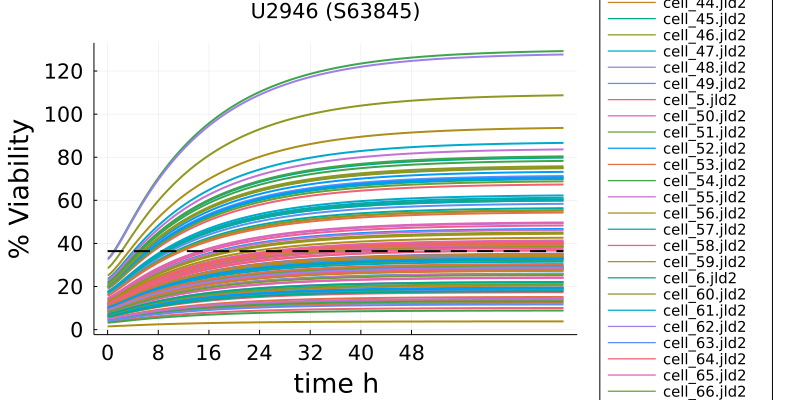

In [13]:

speciesToPlot="AMito"
indexOfSpecies=findfirst(x->speciesToPlot==x,syms)
p6=plot(size=(800,400),ylabel=speciesToPlot)
fileIndex=0
preSimAMito=Vector{Float64}()
allTCs=zeros(numberOfCells,Int(maxTimeTC))
cellIndex=1;
# allInitCond=zeros(length(syms),length(filesInDir))
for file in filesInDir
    global preSimAMito
    JLD2.@load "outputFiles/apoptosis_U2946_Mcl1/"*file sol
    thisTC=sol[indexOfSpecies,:]
    allTCs[cellIndex,:]=thisTC[1:Int(maxTimeTC)]
    push!(preSimAMito,thisTC[1])
    #display(thisTC)
    plot!(p6,thisTC, lw = 2,label=file, title = "U2946",ylabel = "MOMP")
    IJulia.clear_output(true)
    display(p6)
    
#     allInitCond[:,cellIndex]=sol[:,1]
    cellIndex+=1
end
cutoff=maximum(preSimAMito)*1.1 #play with this? perhas +1 is too much
IJulia.clear_output(true)
plot!(p6,[0,maxTimeTC],[cutoff,cutoff], lw = 2,linestyle = :dash,linecolor = :black,label="death thresh")
plot!(legend=:outerright, size=(800,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(xticks = (0:(60*8):(48*60),s), title = "U2946 (S63845)", ylabel="% Viability",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
    fmt = :png)
display(p6)

# png("outputFiles/plots/Viability_U2946_Mcl1")

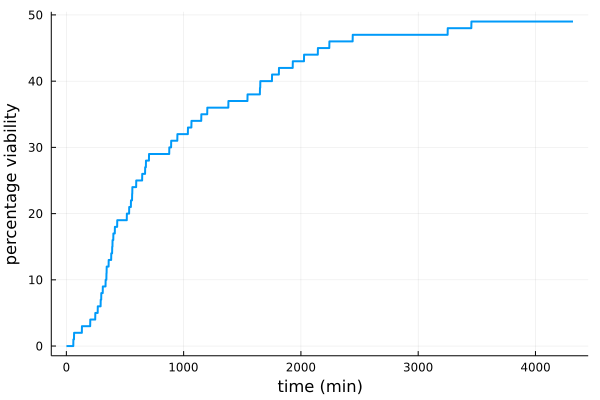

In [14]:
#calculate percentage viability
deathCalling=allTCs.>cutoff
deathOverTime=sum(deathCalling,dims=1)
deathOverTime_Mcl1=(deathOverTime./numberOfCells)*100
viablePercentage_Mcl1 = 100 .- deathOverTime_Mcl1
p7=plot(1:maxTimeTC,deathOverTime_Mcl1', lw = 2,label=false,ylabel="percentage viability",xlabel = "time (min)")
display(p7)

In [17]:
gr()
plotlist = []
aliveCells=findall(x->x==0, deathCalling[:,end])
deadCells=findall(x->x==1, deathCalling[:,end])
liveCellInits=allInitCond[:,aliveCells]
deadCellInits=allInitCond[:,deadCells]
averages=zeros(2,length(syms))
#for i in 1:length(syms)
for i in 1:length(syms)
    averages[1,i]=mean(liveCellInits[i,:])
    averages[2,i]=mean(deadCellInits[i,:]./averages[1,i])
    if abs(1-averages[2,i])>0.2
        liveCellInits[i,:]=liveCellInits[i,:]./averages[1,i]
        deadCellInits[i,:]=deadCellInits[i,:]./averages[1,i]
        #thisPlot=plot([1 2], [liveCellInits[i,:];deadCellInits[i,:]],title=syms[i],kind="box")
        #display(thisPlot)
        pval=pvalue(ApproximateTwoSampleKSTest(liveCellInits[i,:], deadCellInits[i,:]); tail = :both)
        maxylim=maximum(vcat(liveCellInits[i,:],deadCellInits[i,:]))

        thisPlot=boxplot([liveCellInits[i,:],deadCellInits[i,:]], 
            label=["alive n="*string(length(liveCellInits[i,:])) "dead n="*string(length(deadCellInits[i,:]))],
            title=syms[i]*" p="*string(round(pval,digits=7)),ylims=(0,maximum([2,maxylim])),
            legend = false,xtickfontsize=18,ytickfontsize=18,titlefontsize=24,margin=5Plots.mm)
#         display(thisPlot)
        push!(plotlist,thisPlot)
    end
end
plot(plotlist...,size=[150*36,4000])
plot!(layout=(22,2))
# savefig("outputFiles/plots/InitConds_U2946.png")

In [ ]:
mkpath("outputFiles/plots/")
Bcl2=100
BclxL=99
x1 = 0; x2 = 72*60;
p_U2946=plot([x1;x2],[Bcl2;Bcl2],lw=3,linecolor="black",label="ABT-199")
plot!([x1;x2],[BclxL;BclxL],lw=3,linecolor="red",label="A1331852")
plot!(1:maxTimeTC,viablePercentage_Mcl1',lw=3,linecolor="blue",label="S63845")
plot!(legend=:outerright,
    size=(600,300),margin=5Plots.mm)
s=string.(collect(0:12:72))
plot!(xticks = (0:(60*12):(72*60),s),xlim = (0,72*60), ylim = (-10,105), title = "U2946", ylabel="% Viability",xlabel="time h", 
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,legendfontsize=10,
    dpi = 300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_U2946")

## Viability

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_U2946.csv"))

In [ ]:
U2946_viability = plot(df.Inhib,df.ABT199, lw = 3,linecolor="black",label="ABT-199")
plot!(df.Inhib,df.A1331852.-1, lw = 3,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 3,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(600,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
plot!(title = "U2946", ylabel="% Viability",xlabel="% Inhibition",
    xtickfontsize=14,ytickfontsize=14,xguidefontsize=18,yguidefontsize=18,titlefontsize=20,
    fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_U2946_inhibVSviab")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_U2946_32.csv"))

In [ ]:
U2946_viability = plot(df.Inhib,df.ABT199, lw = 2,linecolor="black",label="ABT-199")
plot!(df.Inhib,df.A1331852.-1, lw = 2,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 2,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_U2946_inhibVSviab_32")

In [ ]:
df = DataFrame(CSV.File("../apoptosis-master/Apoptosis_modelFiles/Viability_U2946_32_mod.csv"))

In [ ]:
U2946_viability = plot(df.Inhib,df.ABT199, lw = 2,linecolor="black",label="ABT-199")
plot!(df.Inhib,df.A1331852.-1, lw = 2,linecolor="red",label="A1331852")
plot!(df.Inhib,df.S63845, lw = 2,linecolor="blue",label="S63845")
plot!(legend=false,
    size=(500,400),margin=5Plots.mm)
s=string.(collect(0:8:48))
x_ticks = ["0" "25" "50" "75" "100"];
plot!(ylabel="Viability (%)",xlabel="Inhibition (%)", thickness_scaling=2,
    xticks=(0:0.25:1, x_ticks),
    xtickfontsize=14/2, ylim = (-5,105),ytickfontsize=14/2,xguidefontsize=18/2,
    yguidefontsize=18/2,titlefontsize=20/2,
    dpi=300, fmt = :png)
# ,yaxis=:log
# png("outputFiles/plots/Viability_U2946_inhibVSviab_32_mod")